In [36]:
import numpy as np
import numba
from numba import jit
import pydicom
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
#divnorm=colors.TwoSlopeNorm(vcenter=0.)
import imageio
from scipy import interpolate
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy
import copy
import pickle

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy, unsupervised_wiener, wiener  
from functions import *

In [4]:
lam = 500
n = 400
L_val = 1/2
B_val = 1/5

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [5]:
def normalize_phantom(A, p=0.5):
    n = A.shape[0]
    mu = -np.log(p)/n
    m = np.mean(A[A>0])
    return A*mu/m

A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = normalize_phantom(A1, p=0.5)
A2_norm = normalize_phantom(A2, p=0.5)
A3_norm = normalize_phantom(A3, p=0.5)
A4_norm = normalize_phantom(A4, p=0.5)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [6]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Add live and background and remove any overlapping tumours from liver

In [7]:
L = np.asarray(imageio.imread(f'images/liv.png').sum(axis=2))>260
B = np.asarray(imageio.imread(f'images/background.png').sum(axis=2))>260

Ts_non_overlap = []
for T in Ts:
    if not np.any(T*L):
        Ts_non_overlap.append(T)
T = np.array(Ts_non_overlap).sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)
B = B^(T+L)

In [8]:
T_masked = np.ma.masked_where(~T, T)
L_masked = np.ma.masked_where(~L, L)
B_masked = np.ma.masked_where(~B, B)
masks = [T_masked, L_masked, B_masked]
mask_names = ['T', 'L', 'B']

Get tumour distribution by smoothing the activity.

In [9]:
def get_tumour_dist(T, sigma=3):
    U = gaussian(T, sigma=3)
    U[~T]=0
    return U

U = get_tumour_dist(T, sigma=3)
U[L] += L_val
U[B] += B_val

In [267]:
p = PETImage(A1_norm, 500*U)

In [268]:
p.generate_PET_raw()

In [269]:
p.generate_PET_im()

In [270]:
p.generate_PET_sino()

In [271]:
p.get_probability_sinogram()

In [273]:
p.get_recon_data(['art'], masks, mask_names, correction=None, num_iters=[15], every_ns=[1])

art
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


# Plots for Paper

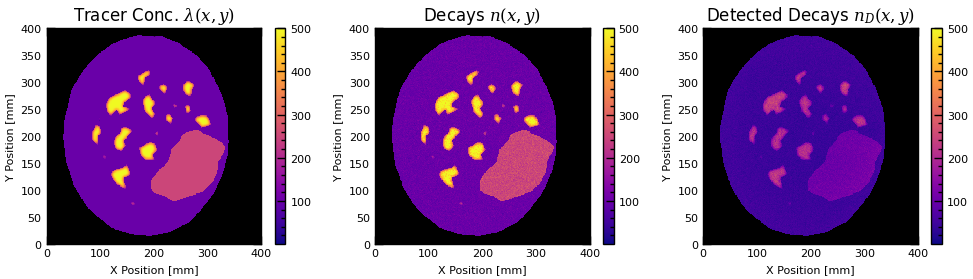

In [275]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
im = ax[0].pcolor(500*U, cmap='plasma', vmin=1, vmax=500,)
c = plt.colorbar(im, ax=ax[0])
c.ax.tick_params(axis='y', labelsize=8)
ax[0].set_title('Tracer Conc. $\lambda(x,y)$', fontsize=12)
im = ax[1].pcolor(p.PET_raw, cmap='plasma', vmin=1, vmax=500,)
c = plt.colorbar(im, ax=ax[1])
c.ax.tick_params(axis='y', labelsize=8)
ax[1].set_title('Decays $n(x,y)$', fontsize=12)
im = ax[2].pcolor(p.PET_im, cmap='plasma', vmin=1, vmax=500,)
c = plt.colorbar(im, ax=ax[2])
c.ax.tick_params(axis='y', labelsize=8)
ax[2].set_title('Detected Decays $n_D(x,y)$', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('images/tumours.png', dpi=200)
plt.show()

In [15]:
ps = [PETImage(A, 500*U) for A in [A1_norm, A2_norm, A3_norm, A4_norm]]
for i,pi in enumerate(ps):
    print(i)
    pi.generate_PET_raw()
    pi.generate_PET_im()

0
1
2
3


<ipython-input-16-d7cf4a7e0a3f>:3: RuntimeWarning: invalid value encountered in true_divide
  q = (ps[i].PET_im - ps[i].PET_raw)/(ps[i].PET_og)


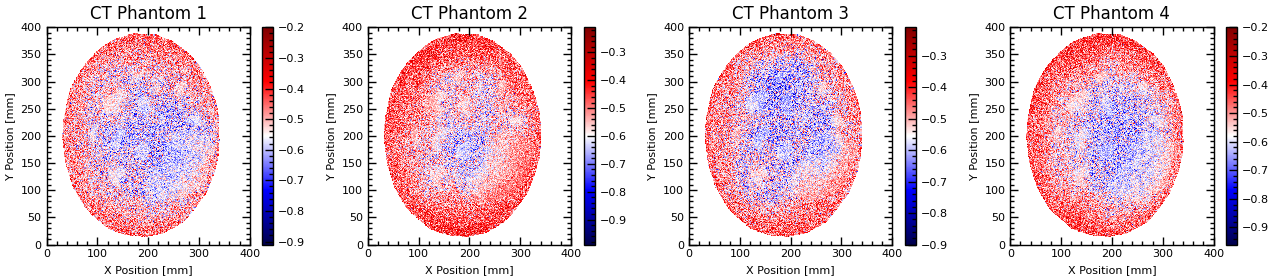

In [16]:
fig, ax = plt.subplots(1,4,figsize=(13,3))
for i in range(4):
    q = (ps[i].PET_im - ps[i].PET_raw)/(ps[i].PET_og)
    im = ax[i].pcolor(q, cmap='seismic')
    c = plt.colorbar(im, ax=ax[i])
    c.ax.tick_params(axis='y', labelsize=8)
    ax[i].set_title(f'CT Phantom {i+1}', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('images/ct_tumour_diff.png', dpi=200)
plt.show()

In [17]:
thetas, rs, sino_att = p.PET_im_sino_theta_bins, p.PET_im_sino_rs_bins, p.PET_im_sino
sino = sino_att/p.PET_im_sino_prob

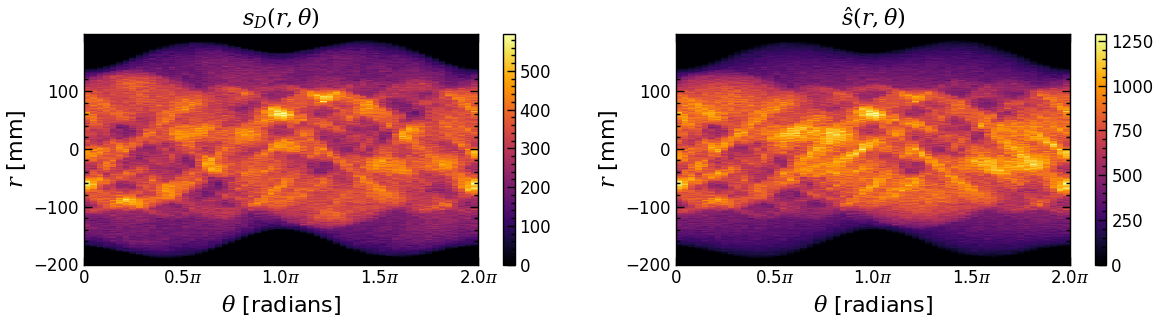

In [18]:
fig, axes = plt.subplots(1,2,figsize=(14,3))
ax = axes[0]
im = ax.pcolor(thetas, rs, sino_att, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$s_D(r,\theta)$')
ax = axes[1]
im = ax.pcolor(thetas, rs, sino, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$\hat{s}(r,\theta)$')
plt.savefig('images/sinos.png', dpi=200)
plt.show()

# Other Stuff

In [45]:
p = PETImage(A1_norm, 500*U)
p.generate_PET_raw()
p.generate_PET_im()
p.generate_PET_sino()
p.get_probability_sinogram()

In [46]:
p_nlm = copy.deepcopy(p)

In [15]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']
iterations = [10, 250, 60, 30, 40, 40, 140, 200, 300, 360]
every_ns = [1, 10, 5, 3, 4, 4, 10, 10, 20, 30] # change osem to 5
dps= np.zeros(len(iterations)).astype(int) +2

algos = ['mlem', 'osem']
iterations = [60, 30]
every_ns = [5, 3] # change osem to 5
dps = np.array(iterations); dps=dps.astype(int)


Create data

In [48]:
%%capture
p.get_recon_data(algos, masks, mask_names, correction=None, num_iters=iterations, every_ns=every_ns)
p_nlm.get_recon_data(algos, masks, mask_names, correction='nlm', num_iters=iterations, every_ns=every_ns)

Save data

In [49]:
f = open("data/recon_normal", "wb")
pickle.dump(p, f) # serialize class instance
f.close()
f = open("data/recon_nlm", "wb")
pickle.dump(p_nlm, f) # serialize class instance
f.close()

Load data

In [9]:
f = open("data/recon_normal.pkl", "rb")
p=pickle.load(f)
f.close()
f = open("data/recon_nlm.pkl", "rb")
p_nlm=pickle.load(f)
f.close()

MSE vs iterations

In [16]:
def plot_all_on_same(p, title, dps, T_val=500, L_val=250, B_val=100):
    fig, axes = plt.subplots(1,3,figsize=(16,5))
    ax = axes[2]
    [ax.plot(np.abs(p.recon_datas[algo].data['T']['BIAS'][dps[i]:])/T_val*100,
              np.sqrt(p.recon_datas[algo].data['T']['VAR'][dps[i]:])/T_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    ax.set_title(r'Tumours')
    #ax.set_ylim(7,14)
    #ax.set_xlim(6,35)


    ax = axes[1]
    [ax.plot(np.abs(p.recon_datas[algo].data['L']['BIAS'][dps[i]:])/L_val*100,
              np.sqrt(p.recon_datas[algo].data['L']['VAR'][dps[i]:])/L_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    ax.set_title(r'Liver')
    ax.legend(ncol=2, fontsize=7, facecolor='white', framealpha=1, frameon=True, loc='lower right')
    #ax.set_ylim(7,19)
    #ax.set_xlim(2,12)
    ax.grid()


    ax = axes[0]
    [ax.plot(np.abs(p.recon_datas[algo].data['B']['BIAS'][dps[i]:])/B_val*100,
              np.sqrt(p.recon_datas[algo].data['B']['VAR'][dps[i]:])/B_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    ax.set_title(r'Background')
    #ax.set_ylim(15,46)
    #ax.set_xlim(2,11)
    
    ax.grid()
    
    fig.text(0.5, -0.05, '$|b|$ [%]', fontsize=20)
    fig.suptitle('$\sigma$ [%]', fontsize=20, x=0, y=0.5, rotation=90)
    plt.grid()
    fig.tight_layout()
    
def plot_compare(p, axes, dps, R, val=100):
    for i in range(10):
        ax = axes.ravel()[i]
        ax.plot(np.abs(p.recon_datas[algos[i]].data[R]['BIAS'][dps[i]:])/val*100,
                  np.sqrt(p.recon_datas[algos[i]].data[R]['VAR'][dps[i]:])/val*100,
               'o--')
        
def plot_mses(p, ax, dps, R, val=100):
    for i in range(10):
        ax.plot(np.array(p.recon_datas[algos[i]].iters) / max(p.recon_datas[algos[i]].iters),
                np.sqrt(p.recon_datas[algos[i]].data[R]['MSE'])/val*100,
                marker=styles[i%len(styles)], color=colors[i%len(colors)],
                ls=linestyles[i%len(linestyles)], lw=1, label=algos[i])

In [17]:
linestyles = ['--', ':']

styles = [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'grey', 'pink')

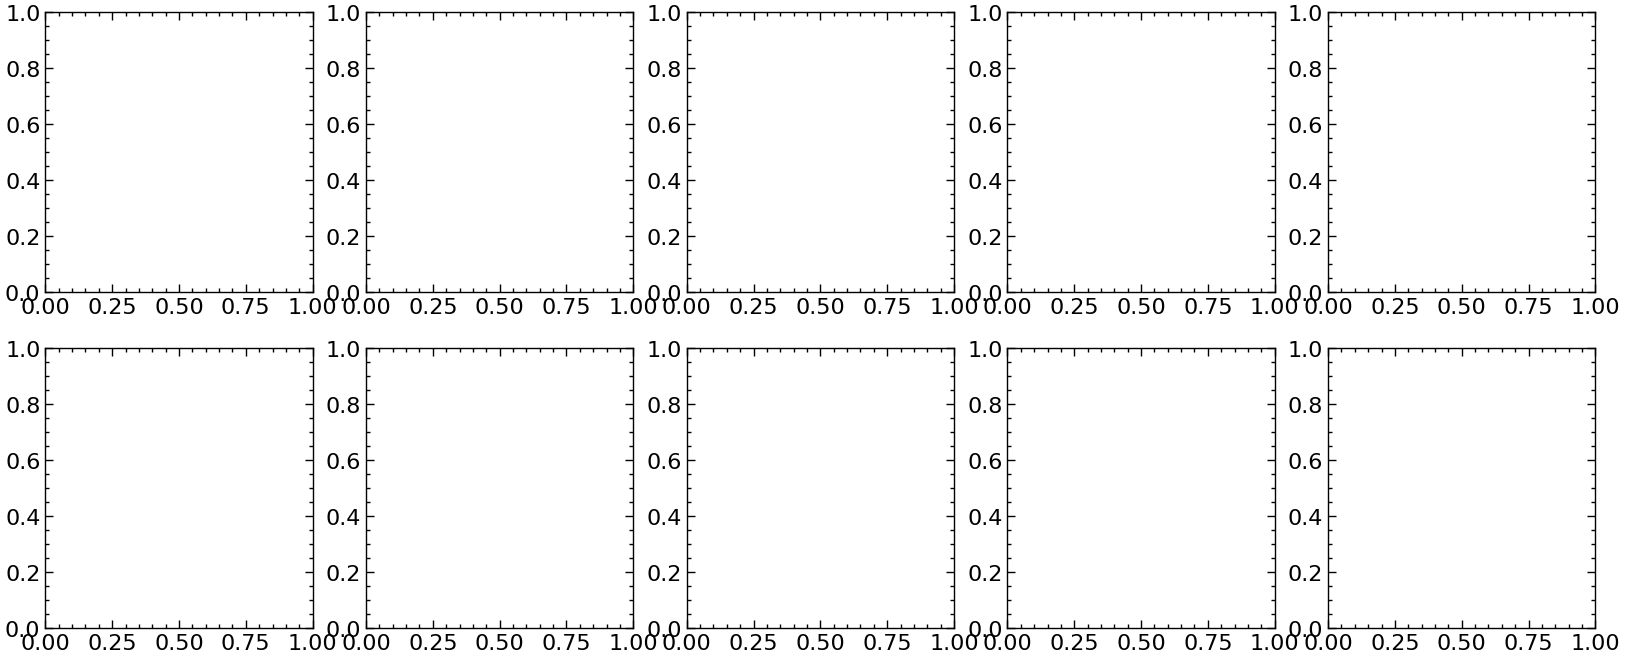

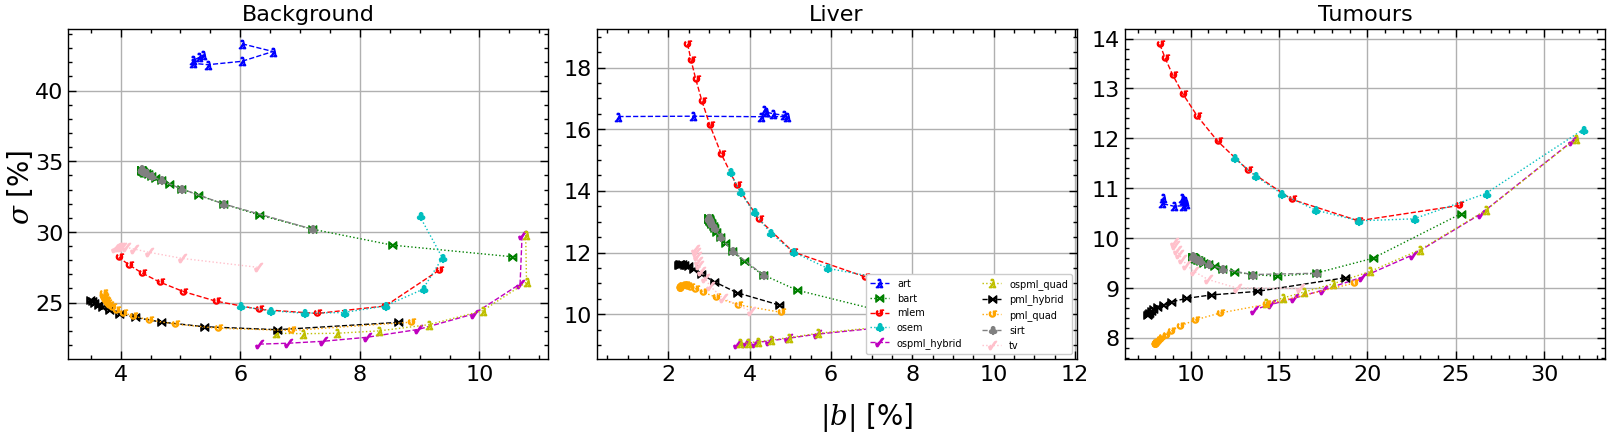

In [18]:
plot_all_on_same(p, 'Bias $b$ vs. Noise $\sigma$ Trade-off Curves', dps=dps)
plt.savefig('plots/bias_noise_tradeoff.png', dpi=200)
plt.show()

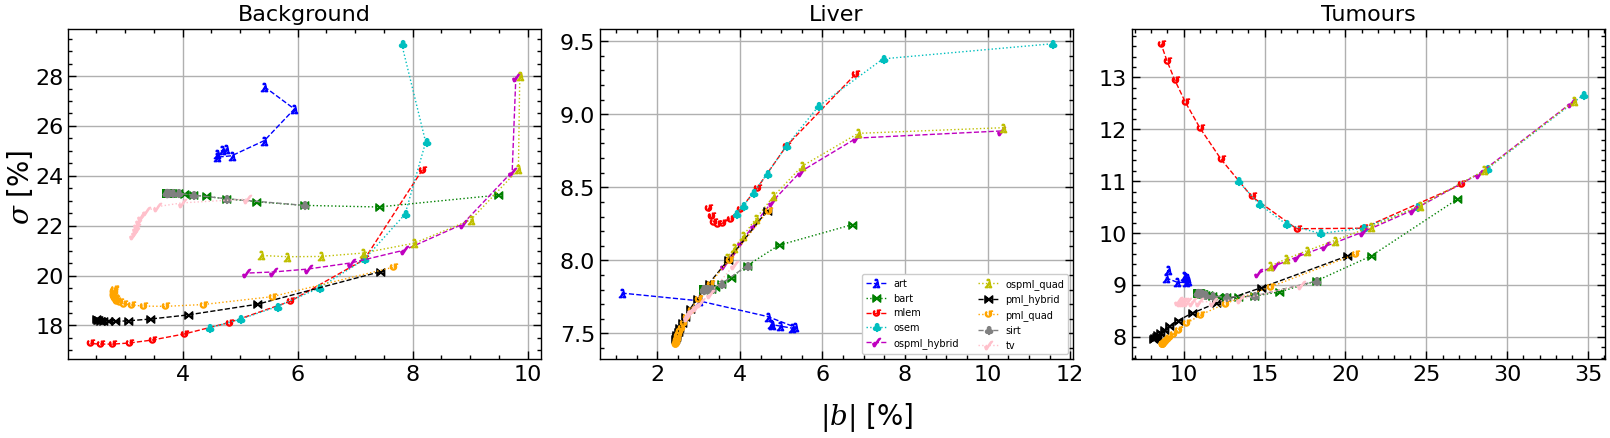

In [19]:
plot_all_on_same(p_nlm, 'Bias $b$ vs. Noise $\sigma$ Trade-off Curves', dps=dps)
plt.savefig('plots/bias_noise_tradeoff_nlm_app.png', dpi=200)
plt.show()

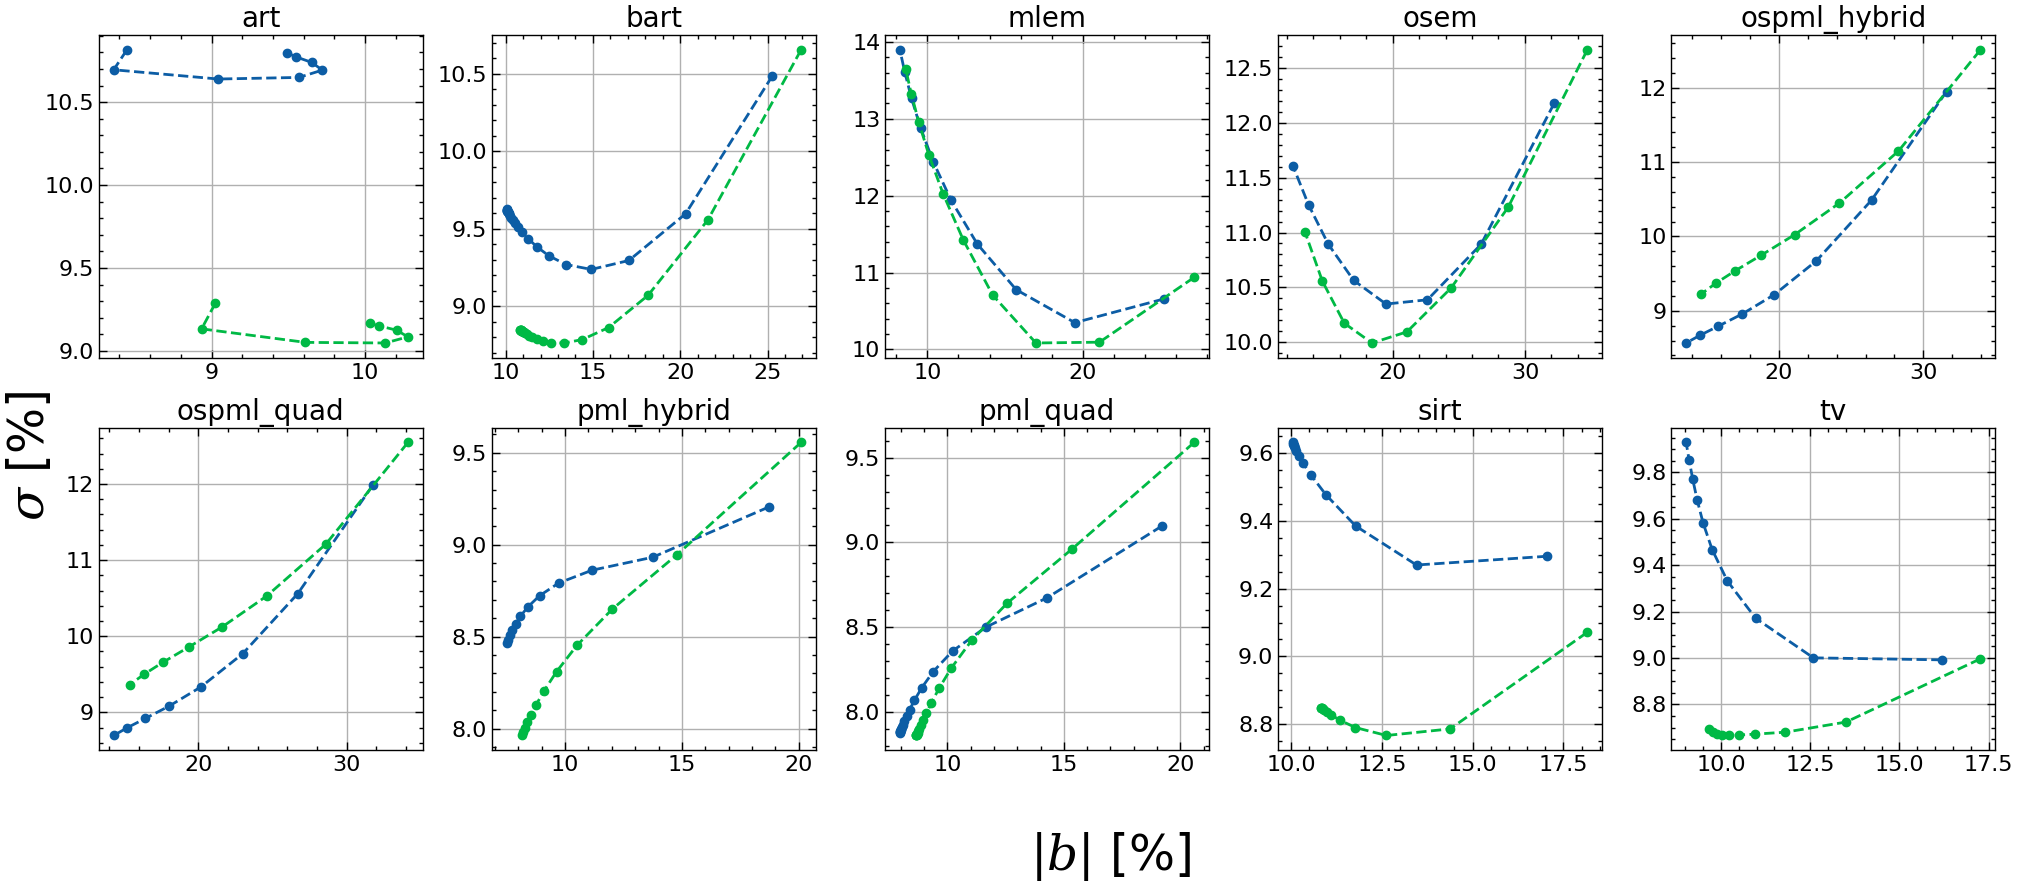

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
plot_compare(p, axes, dps, 'T', val=500)
plot_compare(p_nlm, axes, dps, 'T', val=500)
[ax.set_title(algo, fontsize=20) for ax, algo in zip(axes.ravel(), algos)]
[ax.grid() for ax in axes.ravel()]
fig.tight_layout()
fig.text(0.5, -0.1, '$|b|$ [%]', fontsize=35)
fig.suptitle('$\sigma$ [%]', fontsize=35, x=0, y=0.5, rotation=90)
plt.savefig('plots/compare_tumour.png', dpi=200)
plt.show()

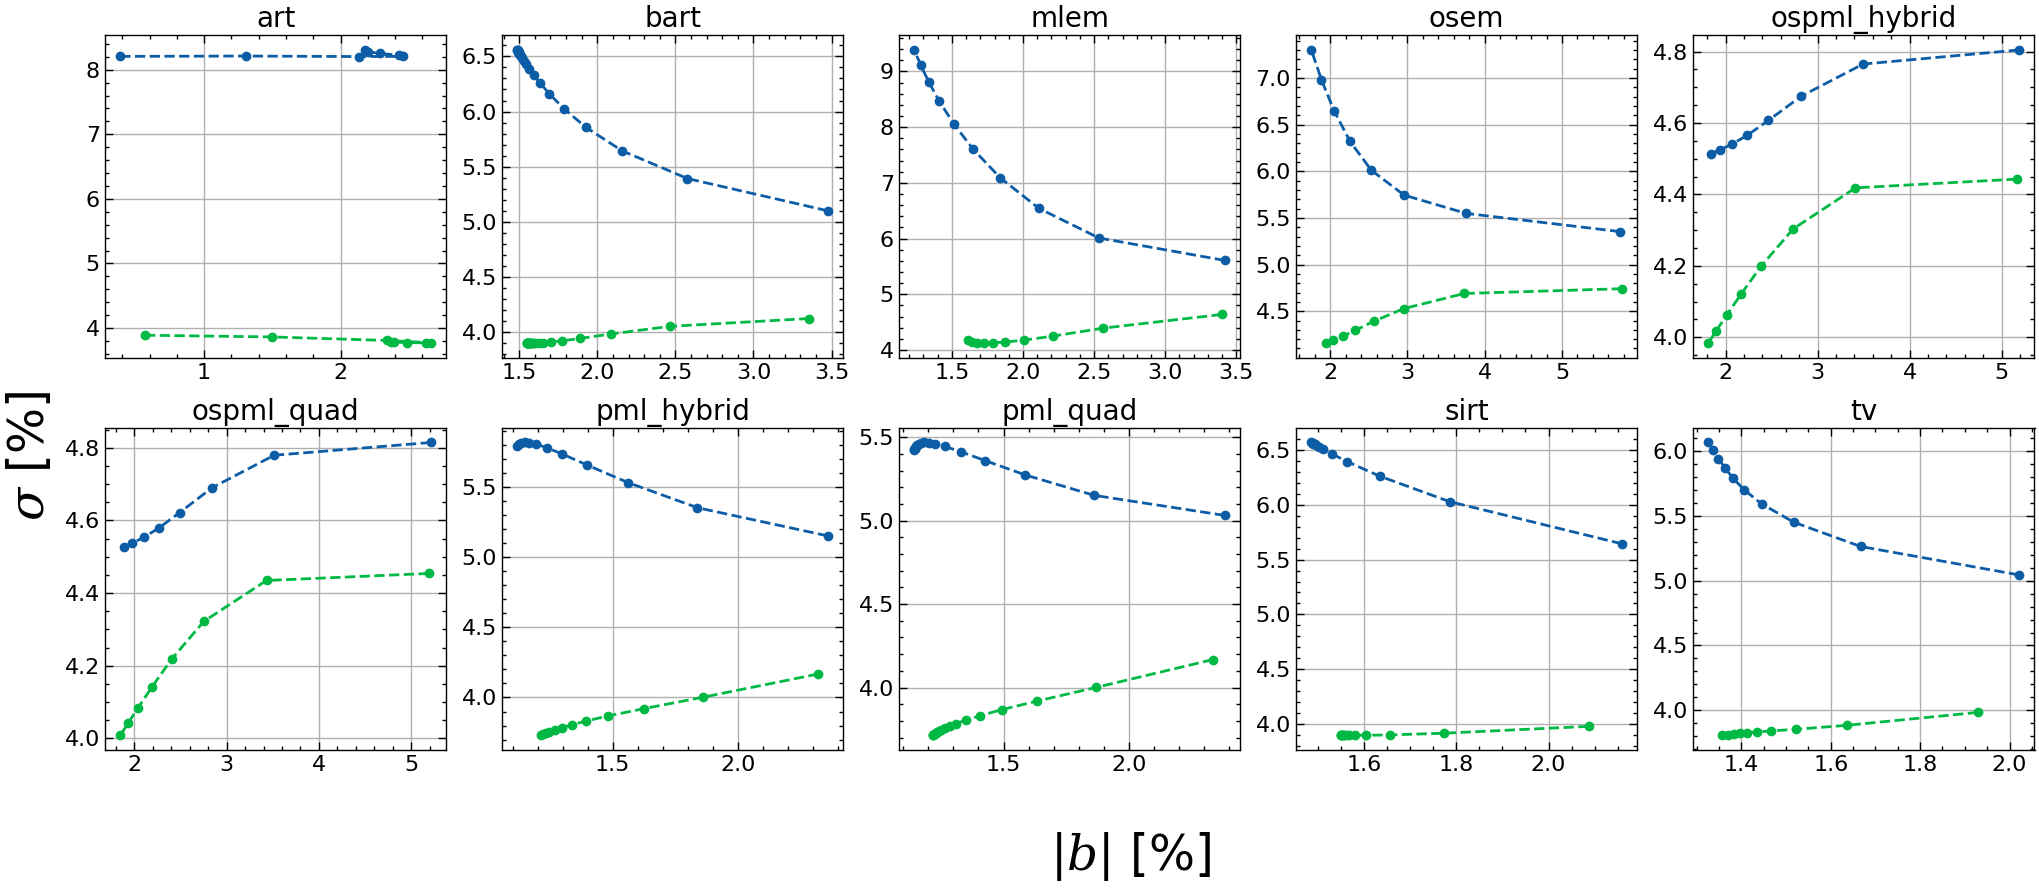

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
plot_compare(p, axes, dps, 'L', val=500)
plot_compare(p_nlm, axes, dps, 'L', val=500)
[ax.set_title(algo, fontsize=20) for ax, algo in zip(axes.ravel(), algos)]
[ax.grid() for ax in axes.ravel()]
fig.tight_layout()
fig.text(0.5, -0.1, '$|b|$ [%]', fontsize=35)
fig.suptitle('$\sigma$ [%]', fontsize=35, x=-0.01, y=0.5, rotation=90)
plt.savefig('plots/compare_liver.png', dpi=200)
plt.show()

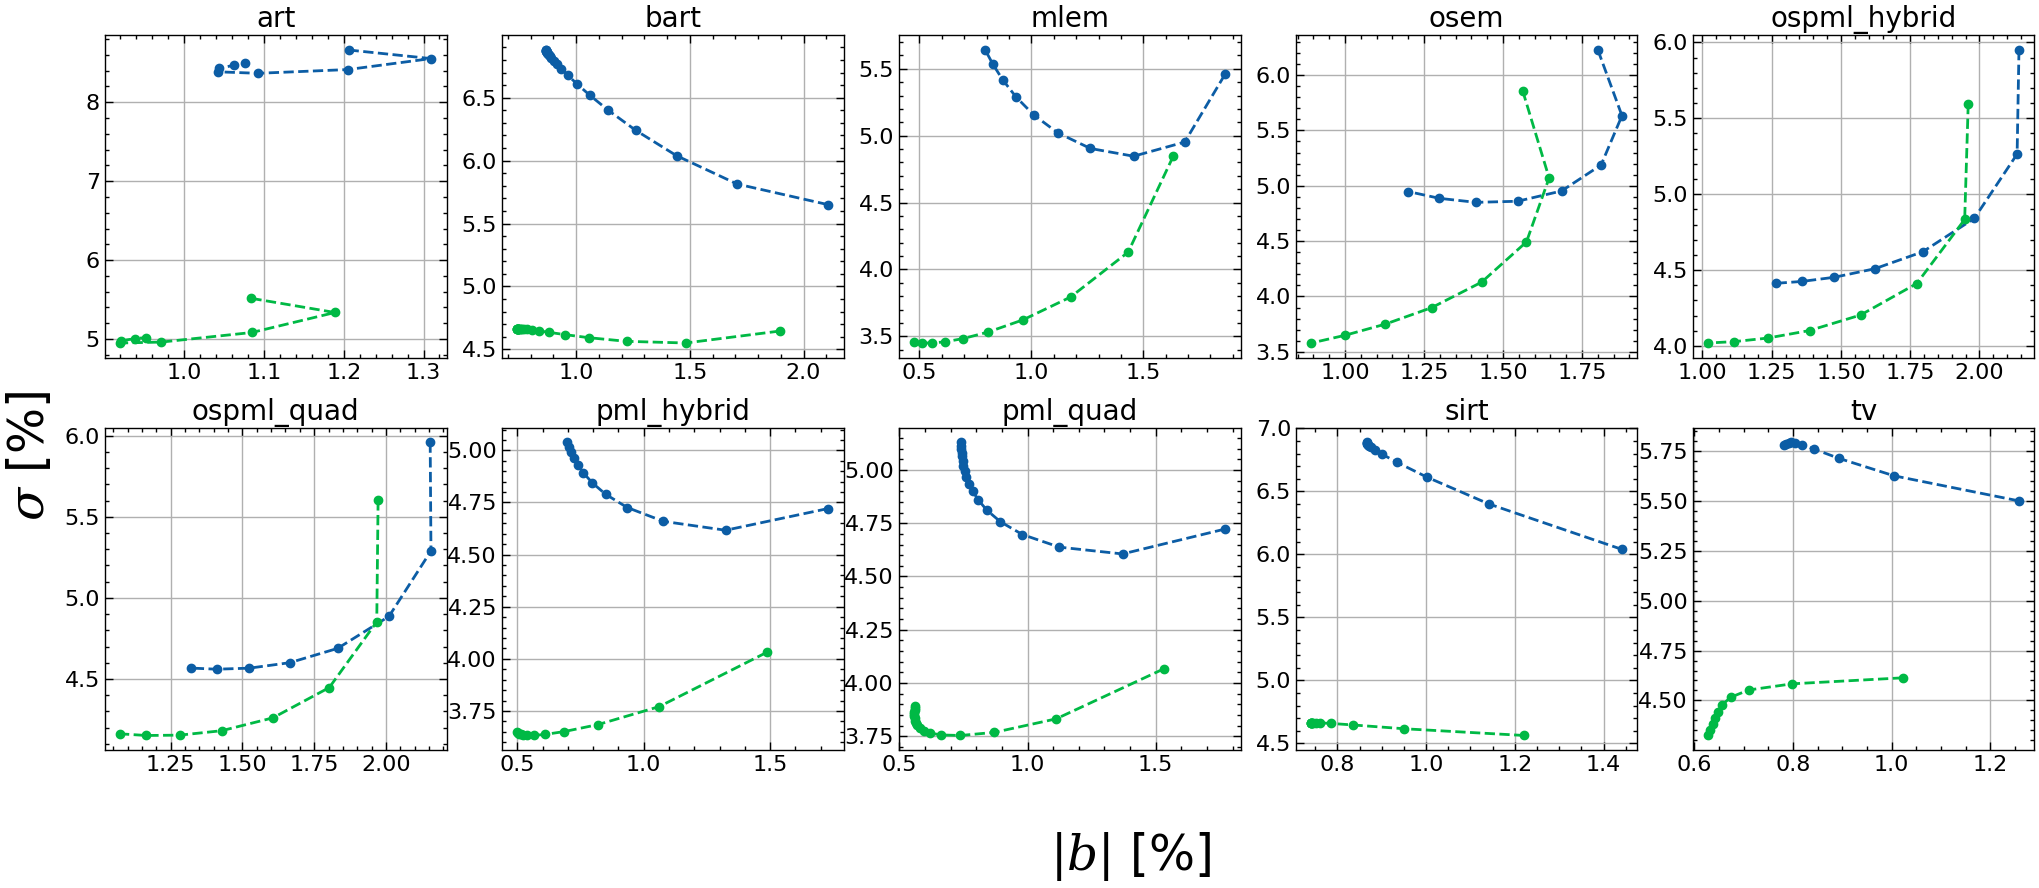

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
plot_compare(p, axes, dps, 'B', val=500)
plot_compare(p_nlm, axes, dps, 'B', val=500)
[ax.set_title(algo, fontsize=20) for ax, algo in zip(axes.ravel(), algos)]
[ax.grid() for ax in axes.ravel()]
fig.tight_layout()
fig.text(0.5, -0.1, '$|b|$ [%]', fontsize=35)
fig.suptitle('$\sigma$ [%]', fontsize=35, x=-0.01, y=0.5, rotation=90)
plt.savefig('plots/compare_background.png', dpi=200)
plt.show()

Mean-Squared Error

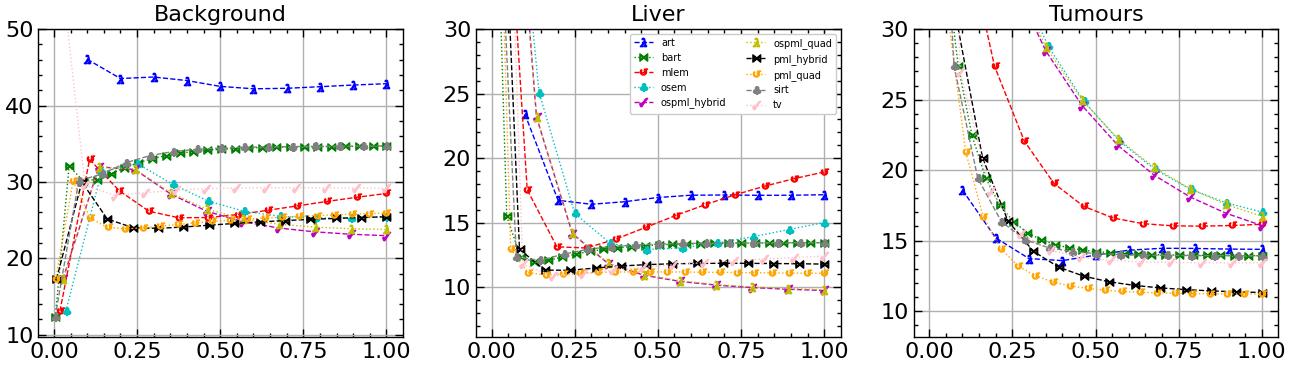

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
plt.subplot(131)
plot_mses(p, ax[0], dps, 'B', val=100)
plt.ylim(top=50)
plt.grid()
plt.title('Background')
plt.subplot(132)
plot_mses(p, ax[1], dps, 'L', val=250)
plt.ylim(top=30)
plt.grid()
plt.legend(ncol=2, fontsize=7, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.title('Liver')
plt.subplot(133)
plot_mses(p, ax[2], dps, 'T', val=500)
plt.ylim(top=30)
plt.grid()
plt.title('Tumours')

plt.savefig('plots/rmse.png', dpi=200)
plt.show()

Images

<ipython-input-24-9004bf58b909>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


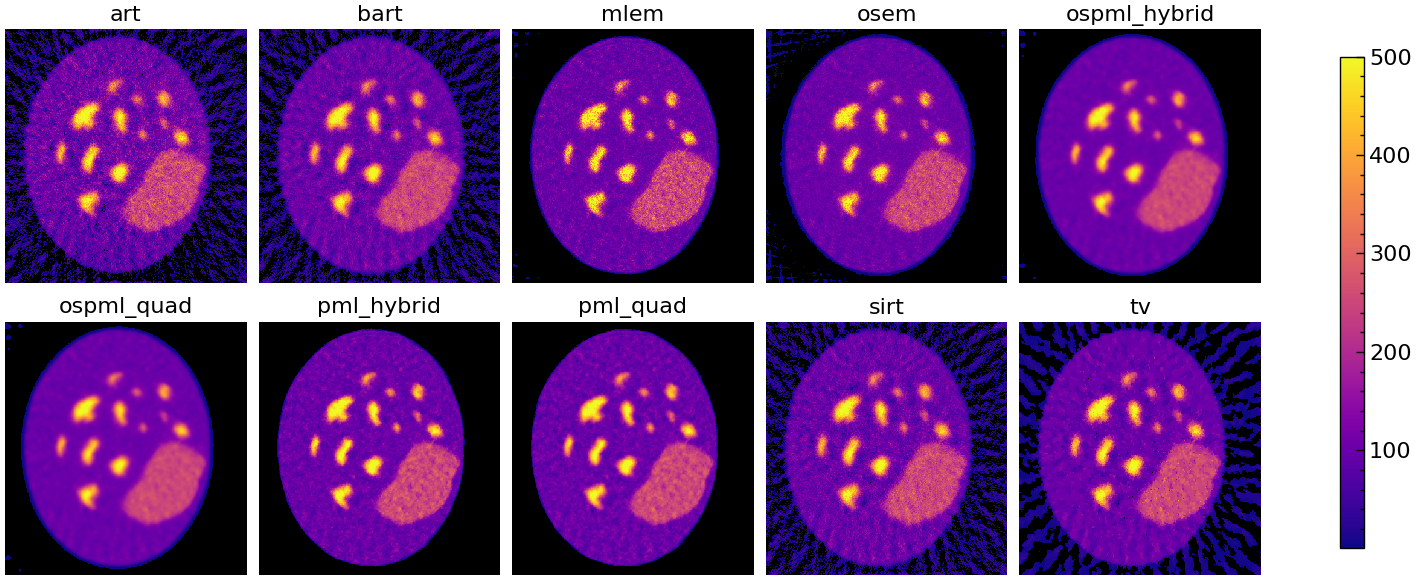

In [24]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.pcolormesh(p.recon_datas[algo].im_bests[0], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('plots/recon.png', dpi=300)
plt.show()

<ipython-input-25-5898085f16ac>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


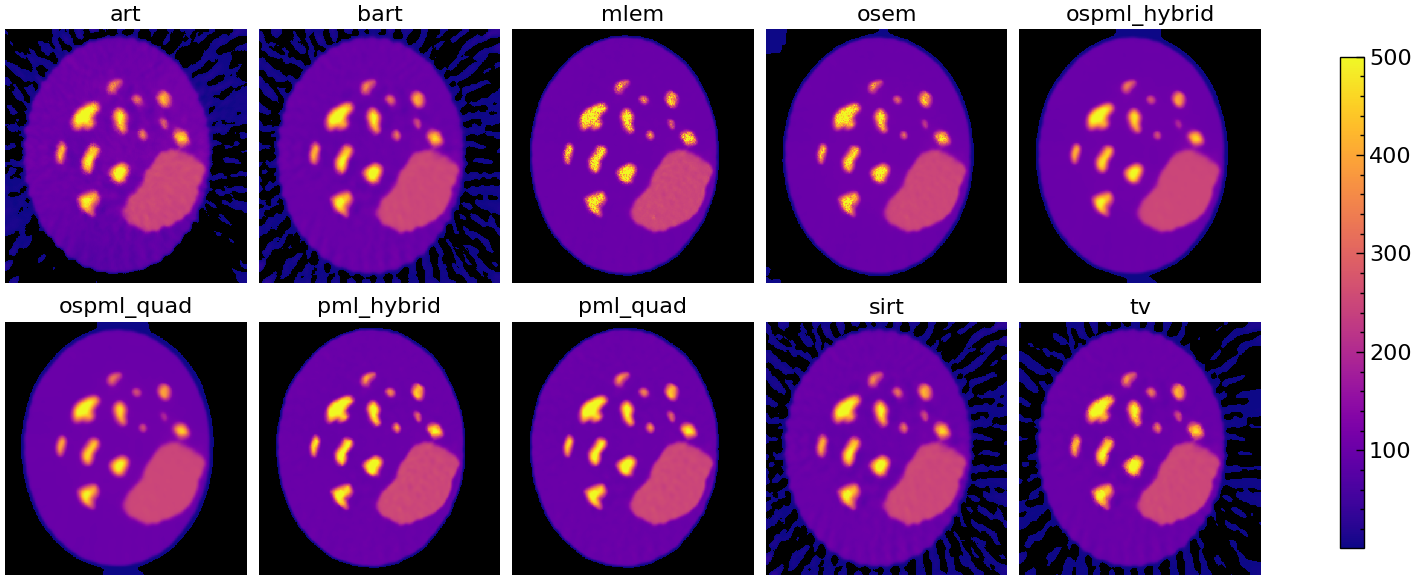

In [25]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.pcolormesh(p_nlm.recon_datas[algo].im_bests[0], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('plots/recon_nlm.png', dpi=300)
plt.show()

# Make Animation

In [42]:
p = PETImage(A1_norm, 500*U, make_ani=True)
p.generate_PET_raw()
p.generate_PET_im()
p.generate_PET_sino()
p.get_probability_sinogram()

In [43]:
algos = ['bart']
iterations = [50]
every_ns = [1]
dps= np.zeros(len(iterations)).astype(int) +2

algos = ['mlem', 'osem']
iterations = [60, 30]
every_ns = [5, 3] # change osem to 5
dps = np.array(iterations); dps=dps.astype(int)


Create data

In [44]:
%%capture
p.get_recon_data(algos, masks, mask_names, correction=None, num_iters=iterations, every_ns=every_ns)

In [50]:
def animate(i):
    ax.clear()
    ax.pcolor(p.recon_datas['bart'].ims[i+1], vmin=1, vmax=500, cmap=cmap)
    ax.set_xlabel('X Position [mm]', fontsize=18)
    ax.set_ylabel('Y Position [mm]', fontsize=18)
    ax.set_title(f'Iteration {i+1}', fontsize=22)
    
fig, ax = plt.subplots(1,1, figsize=(8,7))
im = ax.pcolor(p.recon_datas['bart'].ims[0], vmin=1, vmax=500, cmap=cmap)
ax.set_xlabel('X Position [mm]', fontsize=18)
ax.set_ylabel('Y Position [mm]', fontsize=18)
c = plt.colorbar(im, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=23, interval=50)
ani.save('plots/pow.gif',writer='pillow',fps=3)